# Business Problem - how venues influence the price of real estate? 

For this project, I decided to model the relation between the price of an estate and the type of venues in its neighborhood. 
The objective is to determine whether or not some venues have a direct impact on the price, and if so how is the price affected by it. 

Concretely I will have to: 
1. geolocalize a set of real-estate transactions. As I cannot use geocoder API at such a large scale (too much data), I will have to make the analysis at the level of the neighborhoods. 
2. Calculate the average price per square meter for all neighborhoods in my data set. 
3. List the venues (and the type of venues) for each neighborhood
4. Concatenate my two sources of data into one df
5. Split my data in order to have a train set and a test set 
6. Pick and design the right algorithm to determine & predict the price of an estate given the venues in its neighborhood
7. Evaluate the accuracy of the model

Target Audience: 

Investors may be interested by the independant variables that have a direct impact on the price of a real estate as their interest is to make the greater return on investment. So for instance, if a type X of venues is currently under construction in an area, one can expect to see the price of a real estate in this neighborhood impacted at the end of this project. 

Note: 
1. To make this analysis accurate and a bit pertinent I would need to work at the level of each transaction (i.e. geolocalize each real estate), because not only is it the closest neighborhood that has an impact, but also the distance is a fluctuant & quite relevant parameter (e.g. it may be convinent to have a supermarket nearby your place but maybe not to having seen on the building from your living room. You'd rather have a beautiful park). 
2. Some other factors will be disregarded to make this study simplier. Yet they probably have some big impacts on the price (e.g. construction date of the building, material used for the construction, ecominical & social indicators of the population living in the neighborhood, etc.)

# Import Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


print('Libraries imported.')


Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be 

# Presentation of my Data & its pre-processing

I will use 3 different and complementary sources of data: 

1. A data set that contains all the sales transactions of real estates that occured in Manhattan from 11-18 to 10-19. I will remove the rows with NaN values, transform the dtypes if needed (I will explain why and how below), group my data by neighborhood (I explained the reason in my presentation) and calculate the averige price per neighborhood per square meter. 

2. A second data set will help me to extract the geographical coordinates of every neighborhood in Manhattan. Those data are mandatory to use the 4square API. I will then merge my two dataframes. 

3. Finally I will extract the venues of each Neighborhood from 4square. I will merge the data and use a binary matrix to list & classify types of venues per neighborhood. 

I will first import my main data source as a csv using the following method. Please find below a data set description: 

Manhattan Rolling Sales File.  All Sales From Oct 2018 - Sep 2019.			
"For sales prior to the Final, Neighborhood Name and Descriptive Data reflect the Final Roll 2019/20.  
Sales after the Final Roll, Neighborhood Name and Descriptive Data reflect current data"			
Building Class Category is based on Building Class at Time of Sale.			
Note: Condominium and cooperative sales are on the unit level and understood to have a count of one.			


If you are interested by this dataset, you can download it from this url: https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page

In [2]:
# The code was removed by Watson Studio for sharing.

,NEIGHBORHOOD,ADDRESS,ZIP CODE,GROSS_SQUARE_FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE_PRICE
0,ALPHABET CITY,743 EAST 6TH STREET,10009,3.68,1940,1,S1,"3,200,000"
1,ALPHABET CITY,526 EAST 5TH STREET,10009,5.2,1900,1,A4,"6,100,000"
2,ALPHABET CITY,263 EAST 7TH STREET,10009,3.6,1899,1,C0,"6,300,000"
3,ALPHABET CITY,300 EAST 3RD STREET,10009,7.989,2001,2,C1,"1,950,000"
4,ALPHABET CITY,332 EAST 4TH STREET,10009,17.478,1920,2,C7,"14,000,000"


Let’s have a look at data dimensionality, feature names, and feature types

In [3]:
df_data_0.shape

(6835, 8)

From the output, we can see that the table contains 6835 rows and 8 columns.

We can use the info() method to output some general information about the dataframe:

In [4]:
df_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6835 entries, 0 to 6834
Data columns (total 8 columns):
NEIGHBORHOOD                      6835 non-null object
ADDRESS                           6835 non-null object
ZIP CODE                          6835 non-null int64
GROSS_SQUARE_FEET                 6835 non-null object
YEAR BUILT                        6835 non-null int64
TAX CLASS AT TIME OF SALE         6835 non-null int64
BUILDING CLASS AT TIME OF SALE    6835 non-null object
SALE_PRICE                        6835 non-null object
dtypes: int64(3), object(5)
memory usage: 427.3+ KB


I will clean a bit my df by removing some useless columns (as I explained in my presentation, I will model a price function only based on a few variables)

In [5]:
df_data_0 = df_data_0.drop(["ADDRESS","ZIP CODE","YEAR BUILT","TAX CLASS AT TIME OF SALE", "BUILDING CLASS AT TIME OF SALE"], axis=1)
df_data_0.head()

,NEIGHBORHOOD,GROSS_SQUARE_FEET,SALE_PRICE
0,ALPHABET CITY,3.68,"3,200,000"
1,ALPHABET CITY,5.2,"6,100,000"
2,ALPHABET CITY,3.6,"6,300,000"
3,ALPHABET CITY,7.989,"1,950,000"
4,ALPHABET CITY,17.478,"14,000,000"


In order to compute the quantities, I first need to transform the type (once into str to remove the comma; then a second time into float to apply some basic statistical functions)

In [6]:
df_data_0['SALE_PRICE'] = df_data_0.SALE_PRICE.astype(str)
df_data_0['GROSS_SQUARE_FEET'] = df_data_0.GROSS_SQUARE_FEET.astype(str)

a = df_data_0['SALE_PRICE'].tolist() 
b = df_data_0['GROSS_SQUARE_FEET'].tolist()

a = [i.replace(",","") for i in a]
b = [i.replace(",","") for i in b]

df_data_0['SALE_PRICE'] = a
df_data_0['GROSS_SQUARE_FEET'] = b

df_data_0['SALE_PRICE'] = df_data_0.SALE_PRICE.astype(float)
df_data_0['GROSS_SQUARE_FEET'] = df_data_0.GROSS_SQUARE_FEET.astype(float)

df_data_0.head()

,NEIGHBORHOOD,GROSS_SQUARE_FEET,SALE_PRICE
0,ALPHABET CITY,3.680,3200000.0
1,ALPHABET CITY,5.200,6100000.0
2,ALPHABET CITY,3.600,6300000.0
3,ALPHABET CITY,7.989,1950000.0
4,ALPHABET CITY,17.478,14000000.0


As I'm facing some performance issues with geocoder API, I will use a ready-made data set where I can extract the geographic coordinates for each neighborhood in Manhattan

In [7]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [8]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [9]:
neighborhoods_data = newyork_data['features']

In [10]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [11]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [12]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [13]:
manhattan_data.rename(columns={'Neighborhood': 'NEIGHBORHOOD'},inplace=True)
manhattan_data = manhattan_data.drop("Borough", axis=1)
manhattan_data['NEIGHBORHOOD'] = manhattan_data['NEIGHBORHOOD'].str.upper() 
manhattan_data.head()

,NEIGHBORHOOD,Latitude,Longitude
0,MARBLE HILL,40.876551,-73.910660
1,CHINATOWN,40.715618,-73.994279
2,WASHINGTON HEIGHTS,40.851903,-73.936900
3,INWOOD,40.867684,-73.921210
4,HAMILTON HEIGHTS,40.823604,-73.949688


In [14]:
Lastdf = df_data_0.merge(manhattan_data)
Lastdf.head(50)


,NEIGHBORHOOD,GROSS_SQUARE_FEET,SALE_PRICE,Latitude,Longitude
0,CIVIC CENTER,3.764,7.079588e+06,40.715229,-74.005415
1,CIVIC CENTER,3.764,7.079588e+06,40.715229,-74.005415
2,CIVIC CENTER,3.827,7.900000e+06,40.715229,-74.005415
3,CIVIC CENTER,3.827,7.900000e+06,40.715229,-74.005415
4,CIVIC CENTER,2.220,4.700000e+06,40.715229,-74.005415
5,CIVIC CENTER,2.360,5.250000e+06,40.715229,-74.005415
6,CIVIC CENTER,1.027,2.708040e+06,40.715229,-74.005415
7,CIVIC CENTER,3.094,7.450000e+06,40.715229,-74.005415
8,CIVIC CENTER,2.252,6.250000e+06,40.715229,-74.005415
9,CIVIC CENTER,1.691,4.725000e+06,40.715229,-74.005415


In [15]:
Lastdf['Price/m2'] = (Lastdf.SALE_PRICE / Lastdf.GROSS_SQUARE_FEET)

In [16]:
g = Lastdf.groupby('NEIGHBORHOOD')


In [17]:
g.mean()

,GROSS_SQUARE_FEET,SALE_PRICE,Latitude,Longitude,Price/m2
NEIGHBORHOOD,,,,,
CIVIC CENTER,4.423667,7.026654e+06,40.715229,-74.005415,2.056424e+06
CLINTON,437.652183,2.426260e+06,40.759101,-73.996119,5.123421e+05
EAST VILLAGE,225.606312,5.605654e+06,40.727847,-73.982226,1.017368e+06
FLATIRON,168.858676,1.542258e+07,40.739673,-73.990947,2.340082e+06
GRAMERCY,351.718578,4.411438e+06,40.737210,-73.981376,9.684232e+05
INWOOD,103.560471,2.679084e+06,40.867684,-73.921210,1.268207e+05
LITTLE ITALY,280.019705,5.945024e+06,40.719324,-73.997305,1.501599e+06
LOWER EAST SIDE,416.199264,3.293915e+06,40.717807,-73.980890,7.296687e+05
MANHATTAN VALLEY,472.416203,1.585142e+06,40.797307,-73.964286,1.921495e+05


In [18]:
Lastdf.rename(columns={'NEIGHBORHOOD': 'Neighborhood'},inplace=True)

#  Create a map of Manhattan with neighborhoods superimposed on top.

In [26]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [27]:

map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(Lastdf['Latitude'], Lastdf['Longitude'], Lastdf['Neighborhood']):
 
    folium.CircleMarker(
        [lat, lng],
        radius=2,
       
        color= 'blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

# Extract Data from FourSquare & Merge them with my Df

Now that I have preprocessed my data, I need to get the venues for each neighborhood

In [28]:
CLIENT_ID = 'U1JPB1RU3PAUAYPENRWH3PAQB0KA4CKW2KZSXXTKDKTM5M3Y' # your Foursquare ID
CLIENT_SECRET = 'C05RBLVLNZ4V0AMBQPOSPSOV10HUJIOQI5FCUYTG3CQZORNR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: U1JPB1RU3PAUAYPENRWH3PAQB0KA4CKW2KZSXXTKDKTM5M3Y
CLIENT_SECRET:C05RBLVLNZ4V0AMBQPOSPSOV10HUJIOQI5FCUYTG3CQZORNR


In [29]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [30]:
Limit = 5 
radius = 500 

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            Limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [31]:
Sample = Lastdf.sample(n = 200)

In [32]:
manhattan_venues = getNearbyVenues(names=Sample['Neighborhood'],
                                   latitudes = Sample['Latitude'],
                                   longitudes= Sample['Longitude']
                                  )


INWOOD
LOWER EAST SIDE
CLINTON
CIVIC CENTER
TRIBECA
CLINTON
SOHO
SOHO
MURRAY HILL
LOWER EAST SIDE
ROOSEVELT ISLAND
MURRAY HILL
GRAMERCY
LOWER EAST SIDE
SOHO
MURRAY HILL
LITTLE ITALY
MURRAY HILL
FLATIRON
MURRAY HILL
FLATIRON
LOWER EAST SIDE
GRAMERCY
MORNINGSIDE HEIGHTS
GRAMERCY
MURRAY HILL
LOWER EAST SIDE
LOWER EAST SIDE
LOWER EAST SIDE
TRIBECA
LOWER EAST SIDE
LOWER EAST SIDE
FLATIRON
LOWER EAST SIDE
GRAMERCY
TRIBECA
GRAMERCY
TRIBECA
MURRAY HILL
TRIBECA
GRAMERCY
GRAMERCY
SOHO
FLATIRON
TRIBECA
MURRAY HILL
TRIBECA
GRAMERCY
MANHATTAN VALLEY
FLATIRON
MURRAY HILL
MANHATTAN VALLEY
LOWER EAST SIDE
CLINTON
TRIBECA
SOHO
LOWER EAST SIDE
SOHO
TRIBECA
CLINTON
LITTLE ITALY
TRIBECA
SOHO
LOWER EAST SIDE
TRIBECA
MANHATTAN VALLEY
FLATIRON
GRAMERCY
MURRAY HILL
MURRAY HILL
MANHATTAN VALLEY
TRIBECA
MURRAY HILL
TRIBECA
LOWER EAST SIDE
LOWER EAST SIDE
FLATIRON
TRIBECA
LOWER EAST SIDE
TRIBECA
SOHO
LOWER EAST SIDE
LOWER EAST SIDE
LOWER EAST SIDE
TRIBECA
LOWER EAST SIDE
GRAMERCY
LOWER EAST SIDE
TRIBECA
EAST VIL

# Analyzing each Neighborhood Locations

In [33]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Art Gallery,Arts & Crafts Store,Bakery,Bar,Beer Bar,Beer Store,Bookstore,Burger Joint,Chinese Restaurant,Coffee Shop,Comedy Club,Cycle Studio,Dance Studio,Deli / Bodega,Dessert Shop,Dog Run,Falafel Restaurant,Farmers Market,Filipino Restaurant,Furniture / Home Store,Gourmet Shop,Greek Restaurant,Gym,Hawaiian Restaurant,Hostel,Hotel,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Outdoor Sculpture,Outdoors & Recreation,Park,Peruvian Restaurant,Pet Café,Playground,Poke Place,Pub,Salad Place,Salon / Barbershop,Sandwich Place,Spa,Spanish Restaurant,Tea Room,Theater,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Yoga Studio
0,INWOOD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,INWOOD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,INWOOD,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,INWOOD,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,INWOOD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
manhattan_onehot.rename(columns={'NEIGHBORHOOD': 'Neighborhood'},inplace=True)
 
h = Sample.merge(manhattan_onehot)

h.head()

,Neighborhood,GROSS_SQUARE_FEET,SALE_PRICE,Latitude,Longitude,Price/m2,Art Gallery,Arts & Crafts Store,Bakery,Bar,Beer Bar,Beer Store,Bookstore,Burger Joint,Chinese Restaurant,Coffee Shop,Comedy Club,Cycle Studio,Dance Studio,Deli / Bodega,Dessert Shop,Dog Run,Falafel Restaurant,Farmers Market,Filipino Restaurant,Furniture / Home Store,Gourmet Shop,Greek Restaurant,Gym,Hawaiian Restaurant,Hostel,Hotel,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Outdoor Sculpture,Outdoors & Recreation,Park,Peruvian Restaurant,Pet Café,Playground,Poke Place,Pub,Salad Place,Salon / Barbershop,Sandwich Place,Spa,Spanish Restaurant,Tea Room,Theater,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Yoga Studio
0,INWOOD,2.658,660.0,40.867684,-73.92121,248.306998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,INWOOD,2.658,660.0,40.867684,-73.92121,248.306998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,INWOOD,2.658,660.0,40.867684,-73.92121,248.306998,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,INWOOD,2.658,660.0,40.867684,-73.92121,248.306998,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,INWOOD,2.658,660.0,40.867684,-73.92121,248.306998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Price Modeling - Methodology (Bining & Decision Tree)

# Plot - Price affected by Location

In [35]:
import matplotlib.pyplot as plt
plot = plt.scatter( h.Neighborhood,h.SALE_PRICE,  color='blue')
plt.xlabel("Neighborhood")
plt.ylabel("Sale Price")

plt.rcParams["figure.figsize"] = (20,12)

plt.show()

<Figure size 640x480 with 1 Axes>

# Price affected by a venue within the neighborhood

In [36]:
i = h['Gym']

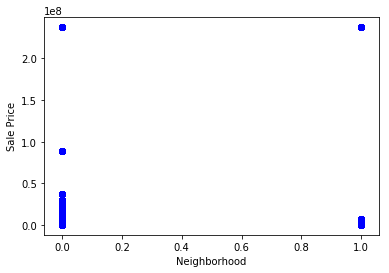

In [37]:
plot = plt.scatter( i,h.SALE_PRICE,  color='blue')
plt.xlabel("Neighborhood")
plt.ylabel("Sale Price")

plt.show()

# Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

# Put in the Dataframe

In [38]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Create the new dataframe and display the top 10 venues for each neighborhood.

In [39]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Art Gallery,Arts & Crafts Store,Bakery,Bar,Beer Bar,Beer Store,Bookstore,Burger Joint,Chinese Restaurant,Coffee Shop,Comedy Club,Cycle Studio,Dance Studio,Deli / Bodega,Dessert Shop,Dog Run,Falafel Restaurant,Farmers Market,Filipino Restaurant,Furniture / Home Store,Gourmet Shop,Greek Restaurant,Gym,Hawaiian Restaurant,Hostel,Hotel,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Outdoor Sculpture,Outdoors & Recreation,Park,Peruvian Restaurant,Pet Café,Playground,Poke Place,Pub,Salad Place,Salon / Barbershop,Sandwich Place,Spa,Spanish Restaurant,Tea Room,Theater,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Yoga Studio
0,CIVIC CENTER,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CLINTON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0
2,EAST VILLAGE,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,FLATIRON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,GRAMERCY,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2
5,INWOOD,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0
6,LITTLE ITALY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.2,0.0,0.2,0.0,0.0,0.0,0.0,0.2,0.0,0.0
7,LOWER EAST SIDE,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2
8,MANHATTAN VALLEY,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0
9,MORNINGSIDE HEIGHTS,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Adding Average house price of each Neighborhood in the Group

In [44]:
neighborhoods_venues_sorted.shape

(14, 6)

In [85]:
manhattan_grouped['Price']=[14256,18567,9657,10456,10250,10087,9021,17105,11540,11078,12750,18050,14330,14915]

In [86]:
h = manhattan_grouped
h.head(14)

,Neighborhood,Art Gallery,Arts & Crafts Store,Bakery,Bar,Beer Bar,Beer Store,Bookstore,Burger Joint,Chinese Restaurant,Coffee Shop,Comedy Club,Cycle Studio,Dance Studio,Deli / Bodega,Dessert Shop,Dog Run,Falafel Restaurant,Farmers Market,Filipino Restaurant,Furniture / Home Store,Gourmet Shop,Greek Restaurant,Gym,Hawaiian Restaurant,Hostel,Hotel,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Outdoor Sculpture,Outdoors & Recreation,Park,Peruvian Restaurant,Pet Café,Playground,Poke Place,Pub,Salad Place,Salon / Barbershop,Sandwich Place,Spa,Spanish Restaurant,Tea Room,Theater,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Yoga Studio,Price
0,CIVIC CENTER,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14256
1,CLINTON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,18567
2,EAST VILLAGE,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9657
3,FLATIRON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10456
4,GRAMERCY,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,10250
5,INWOOD,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,10087
6,LITTLE ITALY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.2,0.0,0.2,0.0,0.0,0.0,0.0,0.2,0.0,0.0,9021
7,LOWER EAST SIDE,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,17105
8,MANHATTAN VALLEY,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,11540
9,MORNINGSIDE HEIGHTS,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11078


# Binning
There is the range of Avg price so binned the price into 3 distinct values


('Average level','Above Average','High level')
Visualizing the bins

Text(0.5, 1.0, 'Price bins')

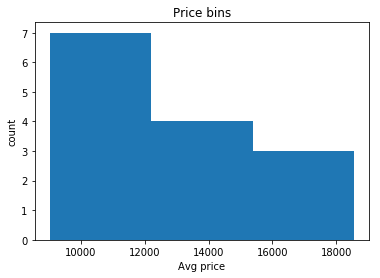

In [93]:
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot
plt.pyplot.hist(h["Price"],bins=3)

# set x/y labels and plot title
plt.pyplot.xlabel("Avg price")
plt.pyplot.ylabel("count")
plt.pyplot.title("Price bins")

In [98]:
bins = np.linspace(min(h["Price"]), max(h["Price"]), 4)
bins

array([ 9021., 12203., 15385., 18567.])

In [99]:
group_names = ['Average level', 'Above Average','High level']

In [100]:
h['Price-Categories'] = pd.cut(h['Price'], bins, labels=group_names, include_lowest=True )
h[['Price','Price-Categories']].head()

,Price,Price-Categories
0,14256,Above Average
1,18567,High level
2,9657,Average level
3,10456,Average level
4,10250,Average level


In [101]:
h.head()

,Neighborhood,Art Gallery,Arts & Crafts Store,Bakery,Bar,Beer Bar,Beer Store,Bookstore,Burger Joint,Chinese Restaurant,Coffee Shop,Comedy Club,Cycle Studio,Dance Studio,Deli / Bodega,Dessert Shop,Dog Run,Falafel Restaurant,Farmers Market,Filipino Restaurant,Furniture / Home Store,Gourmet Shop,Greek Restaurant,Gym,Hawaiian Restaurant,Hostel,Hotel,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Outdoor Sculpture,Outdoors & Recreation,Park,Peruvian Restaurant,Pet Café,Playground,Poke Place,Pub,Salad Place,Salon / Barbershop,Sandwich Place,Spa,Spanish Restaurant,Tea Room,Theater,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Yoga Studio,Price,Price-Categories
0,CIVIC CENTER,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14256,Above Average
1,CLINTON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,18567,High level
2,EAST VILLAGE,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9657,Average level
3,FLATIRON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10456,Average level
4,GRAMERCY,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,10250,Average level


# Use a decision tree to estimate the price given the most common venues

#### Creating train and test dataset
Train/Test Split involves splitting the dataset into training and testing sets respectively, which are mutually exclusive. After which, you train with the training set and test with the testing set. 
This will provide a more accurate evaluation on out-of-sample accuracy because the testing dataset is not part of the dataset that have been used to train the data. It is more realistic for real world problems.

This means that we know the outcome of each data point in this dataset, making it great to test with! And since this data has not been used to train the model, the model has no knowledge of the outcome of these data points. So, in essence, it’s truly an out-of-sample testing.



declare the following variables: <br>

<ul>
    <li> <b> X </b> as the <b> Feature Matrix </b> (data of my_data) </li>
    <li> <b> y </b> as the <b> response vector (target) </b> </li>
</ul>
Remove the column containing the target name since it doesn't contain numeric values.

In [107]:
X = h.drop('Neighborhood', axis=1)
X = X.drop('Price', axis=1)
X = X.drop('Price-Categories',axis=1)

X.head()

,Art Gallery,Arts & Crafts Store,Bakery,Bar,Beer Bar,Beer Store,Bookstore,Burger Joint,Chinese Restaurant,Coffee Shop,Comedy Club,Cycle Studio,Dance Studio,Deli / Bodega,Dessert Shop,Dog Run,Falafel Restaurant,Farmers Market,Filipino Restaurant,Furniture / Home Store,Gourmet Shop,Greek Restaurant,Gym,Hawaiian Restaurant,Hostel,Hotel,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Outdoor Sculpture,Outdoors & Recreation,Park,Peruvian Restaurant,Pet Café,Playground,Poke Place,Pub,Salad Place,Salon / Barbershop,Sandwich Place,Spa,Spanish Restaurant,Tea Room,Theater,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Yoga Studio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2


In [108]:
y = h["Price-Categories"]
y[0:5]

0    Above Average
1       High level
2    Average level
3    Average level
4    Average level
Name: Price-Categories, dtype: category
Categories (3, object): [Average level < Above Average < High level]

In [109]:
from sklearn.model_selection import train_test_split

In [110]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

In [112]:
from sklearn.tree import DecisionTreeClassifier

PriceTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
PriceTree # it shows the default parameters

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [113]:
PriceTree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [116]:
h.shape

(14, 56)

In [114]:
predTree = PriceTree.predict(X_testset)

In [115]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.6


# Results 

In [118]:
 !conda install -c conda-forge pydotplus -y

from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pydotplus-2.0.2            |     pyhd1c1de3_3          23 KB  conda-forge

The following NEW packages will be INSTALLED:

    pydotplus: 2.0.2-pyhd1c1de3_3 conda-forge


pydotplus-2.0.2      | 23 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


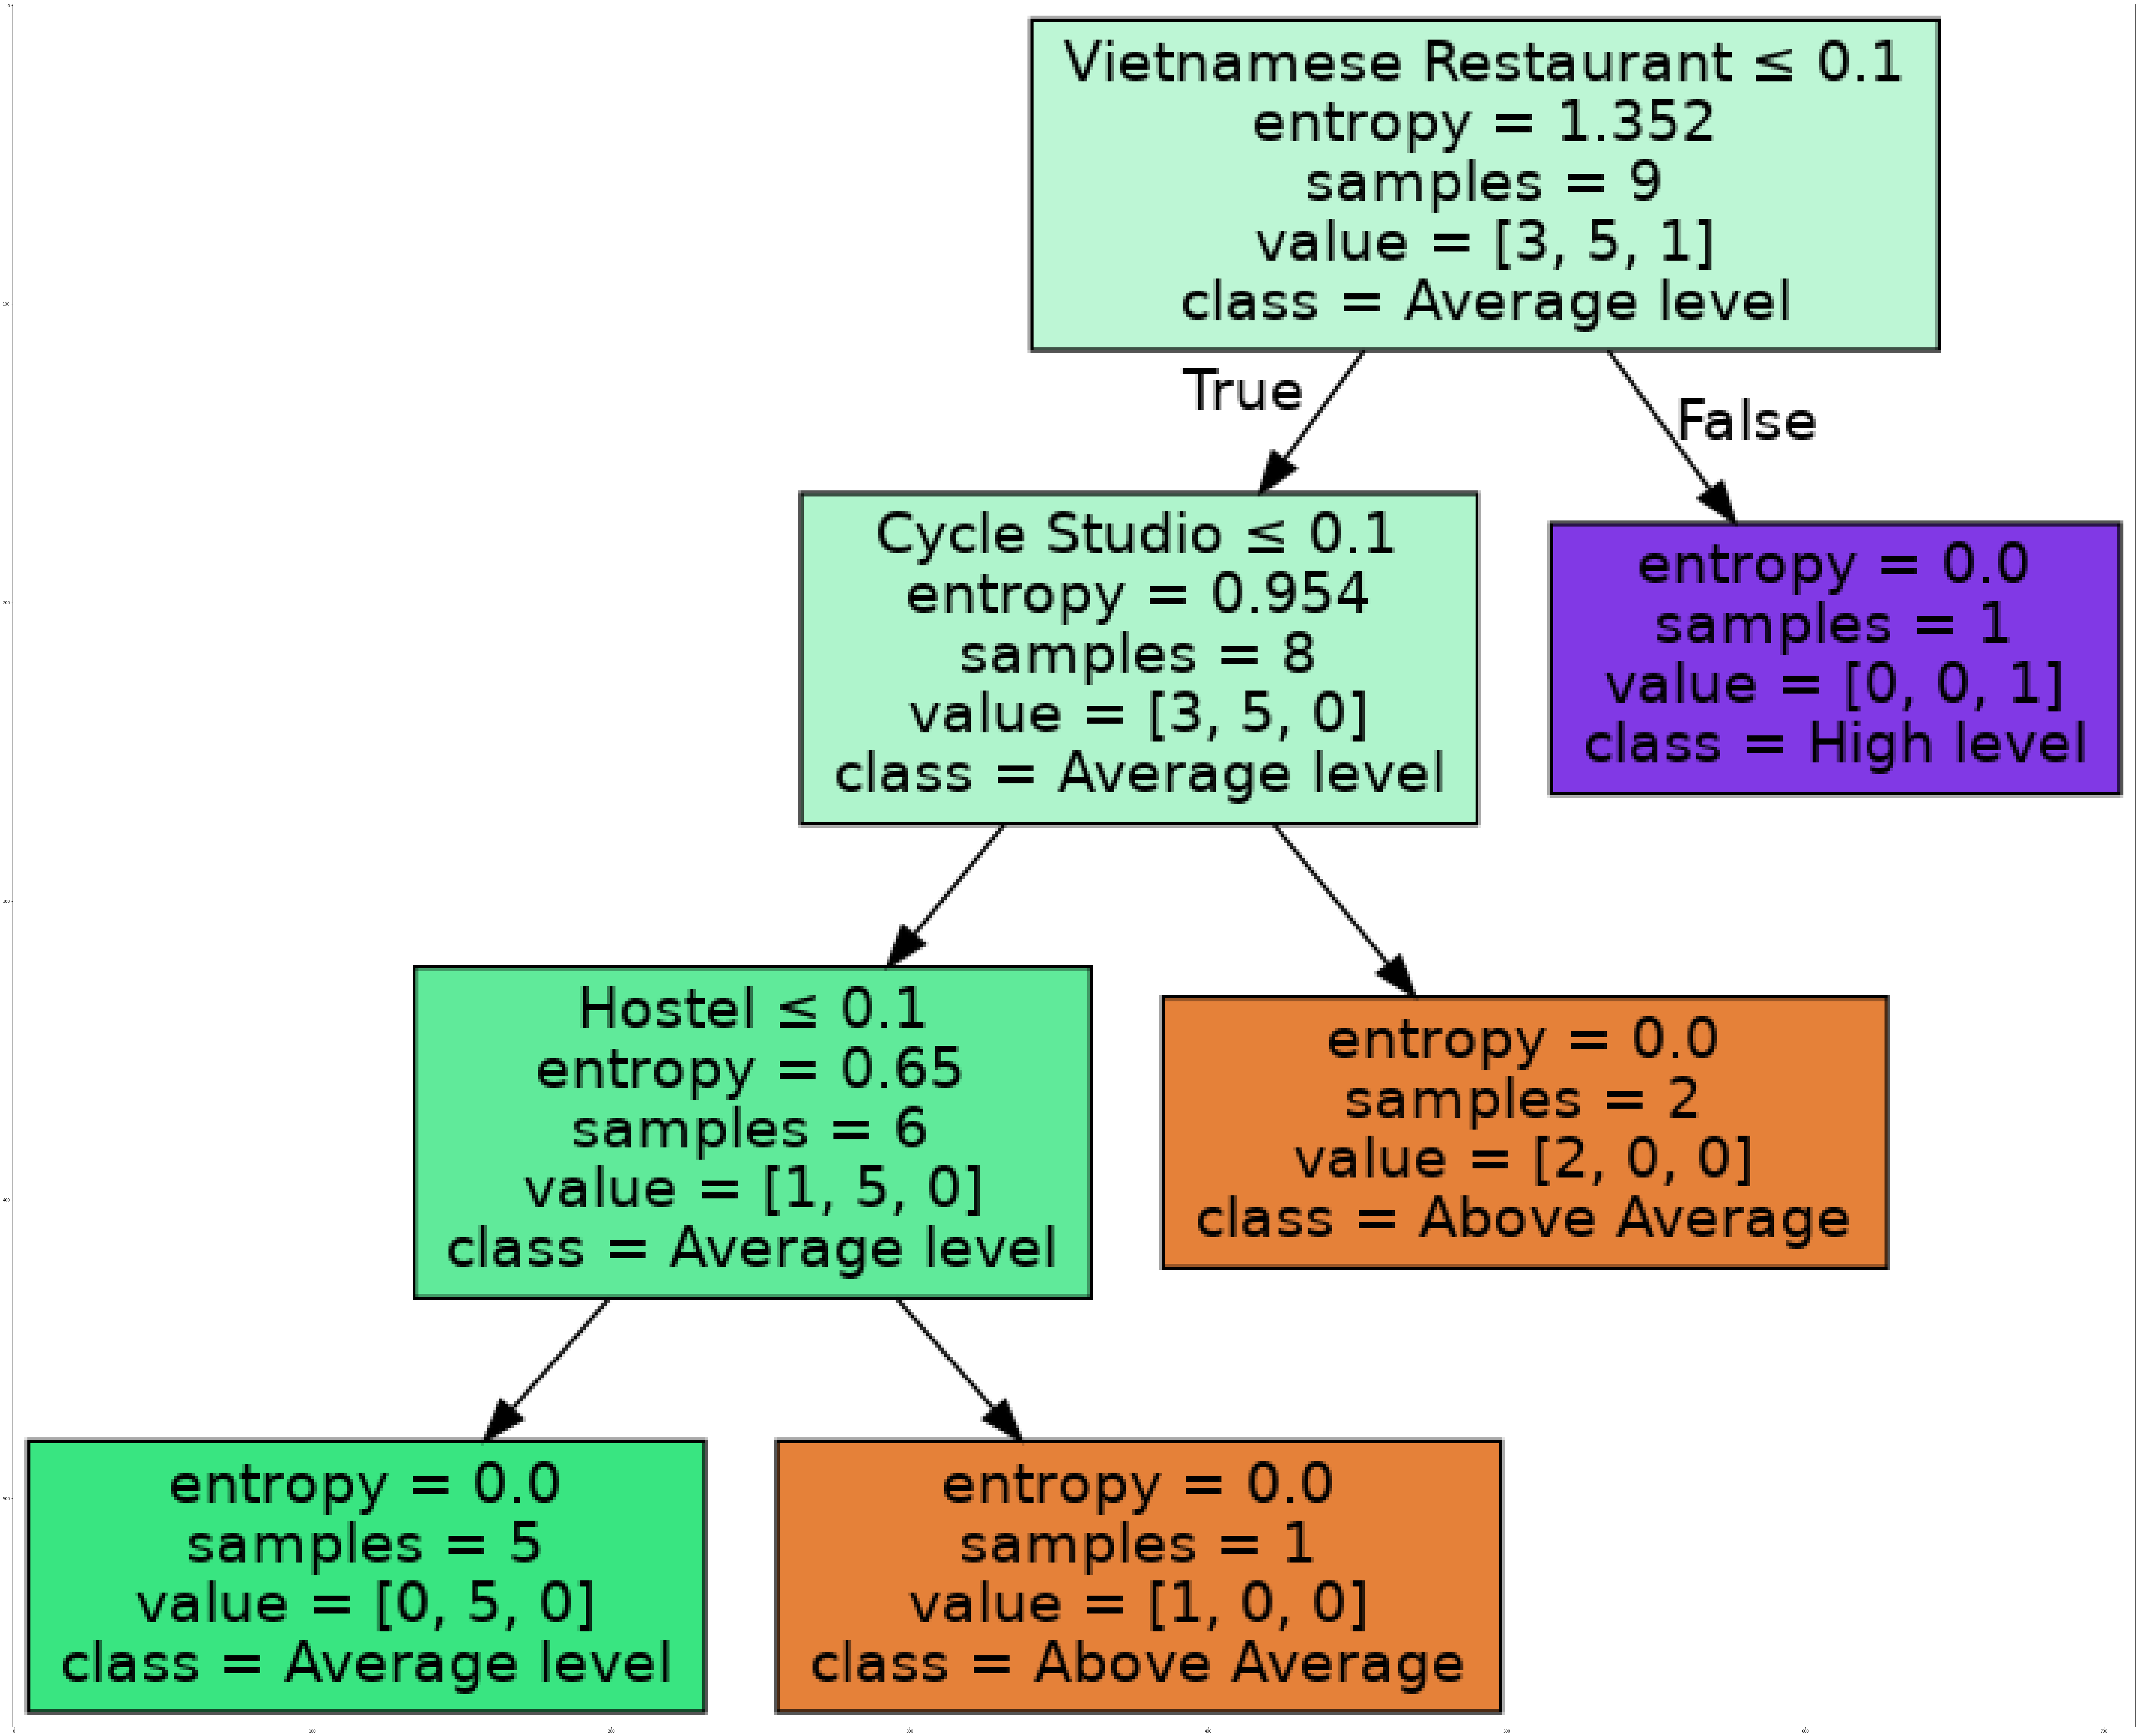

In [121]:
dot_data = StringIO()
filename = "Pricetree.png"
featureNames = h.columns[0:53]
targetNames = h["Price-Categories"].unique().tolist()
out=tree.export_graphviz(PriceTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Observations, advices & remarks

# Conclusions